In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import r2_score, mean_absolute_error
try:
    from chronos import BaseChronosPipeline as ChronosPipe
except Exception:
    from chronos import ChronosPipeline as ChronosPipe
sns.set()


c:\Users\Administrator\Desktop\PROYECTOS\FORECASTING\FORECASTING\.venv_chronos\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def _best_dtype():
    if torch.cuda.is_available():
        try:
            torch.zeros(1, dtype=torch.bfloat16, device="cuda")
            return torch.bfloat16
        except Exception:
            return torch.float16
    return torch.float32

DEVICE_MAP = "cuda" if torch.cuda.is_available() else "auto"
print(DEVICE_MAP)
def download_yf(ticker, period="2y", interval="1d"):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    if df is None or df.empty:
        raise ValueError("No data")
    if isinstance(df.columns, pd.MultiIndex):
        if ("Close", ticker) in df.columns:
            close = df[("Close", ticker)]
        elif ("Adj Close", ticker) in df.columns:
            close = df[("Adj Close", ticker)]
        elif "Close" in df.columns.get_level_values(0):
            c = df["Close"]
            close = c.iloc[:,0] if isinstance(c, pd.DataFrame) else c
        elif "Adj Close" in df.columns.get_level_values(0):
            c = df["Adj Close"]
            close = c.iloc[:,0] if isinstance(c, pd.DataFrame) else c
        else:
            num = df.select_dtypes(include=[np.number])
            if num.shape[1] == 0:
                raise ValueError("No numeric columns")
            close = num.iloc[:,0]
    else:
        if "Close" in df.columns:
            close = df["Close"]
        elif "Adj Close" in df.columns:
            close = df["Adj Close"]
        else:
            num = df.select_dtypes(include=[np.number])
            if num.shape[1] == 0:
                raise ValueError("No numeric columns")
            close = num.iloc[:,0]
    x = df.reset_index()
    ds = x.iloc[:,0]
    out = pd.DataFrame({"ds": pd.to_datetime(ds), "y": pd.to_numeric(pd.Series(close).reset_index(drop=True), errors="coerce")})
    out = out.dropna()
    out = out.sort_values("ds")
    return out

def make_future_index(last_date, steps, freq="D"):
    return pd.date_range(start=last_date + pd.Timedelta(1, unit=freq), periods=steps, freq=freq)

def load_pipeline():
    return ChronosPipe.from_pretrained("amazon/chronos-t5-large", device_map=DEVICE_MAP, torch_dtype=_best_dtype())

def forecast(pipe, series, horizon, n_samples=200):
    s = np.asarray(series).reshape(-1).astype(np.float32)
    if hasattr(pipe, "predict_quantiles"):
        qs, mean = pipe.predict_quantiles(context=torch.tensor(s), prediction_length=horizon, quantile_levels=[0.05,0.5,0.95])
        mean = mean.detach().cpu().numpy()
        qs = qs.detach().cpu().numpy()
        mean = np.asarray(mean).reshape(-1)
        p05 = np.asarray(qs[0,:,0]).reshape(-1)
        p95 = np.asarray(qs[0,:,2]).reshape(-1)
    else:
        samples = pipe.predict(context=s, prediction_length=horizon, num_samples=n_samples)
        samples = np.asarray(samples)
        mean = samples.mean(axis=0).reshape(-1)
        p05 = np.quantile(samples, 0.05, axis=0).reshape(-1)
        p95 = np.quantile(samples, 0.95, axis=0).reshape(-1)
    return mean, p05, p95

def plot_forecast(hist_df, fc_df, title):
    fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(ax=ax, data=hist_df, x="ds", y="y", label="Histórico")
    sns.lineplot(ax=ax, data=fc_df, x="ds", y="mean", label="Pronóstico")
    ax.fill_between(fc_df["ds"], fc_df["p05"], fc_df["p95"], alpha=0.2, linewidth=0)
    ax.set_title(title); ax.set_xlabel("Fecha"); ax.set_ylabel("Valor"); ax.legend()
    plt.show()

def plot_eval(df_train, df_test, df_fc, title):
    fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(ax=ax, data=df_train, x="ds", y="y", label="Train")
    sns.lineplot(ax=ax, data=df_test, x="ds", y="y", label="Test (real)")
    sns.lineplot(ax=ax, data=df_fc, x="ds", y="mean", label="Pred")
    ax.fill_between(df_fc["ds"], df_fc["p05"], df_fc["p95"], alpha=0.2, linewidth=0)
    ax.set_title(title); ax.set_xlabel("Fecha"); ax.set_ylabel("Valor"); ax.legend()
    plt.show()


cuda


In [ ]:

TOKENS_CRYPTO = [
    ("BTC-USD","Bitcoin"),("ETH-USD","Ethereum"),("BNB-USD","BNB"),
    ("SOL-USD","Solana"),("XRP-USD","XRP"),("DOGE-USD","Dogecoin"),
    ("ADA-USD","Cardano"),("TON-USD","Toncoin"),("DOT-USD","Polkadot"),
    ("AVAX-USD","Avalanche")
]
ACCIONES_EJEMPLO = [
    ("AAPL","Apple"),("MSFT","Microsoft"),("NVDA","NVIDIA"),
    ("AMZN","Amazon"),("GOOGL","Alphabet"),("META","Meta"),
    ("TSLA","Tesla"),("NFLX","Netflix"),("AMD","AMD"),("INTC","Intel")
]

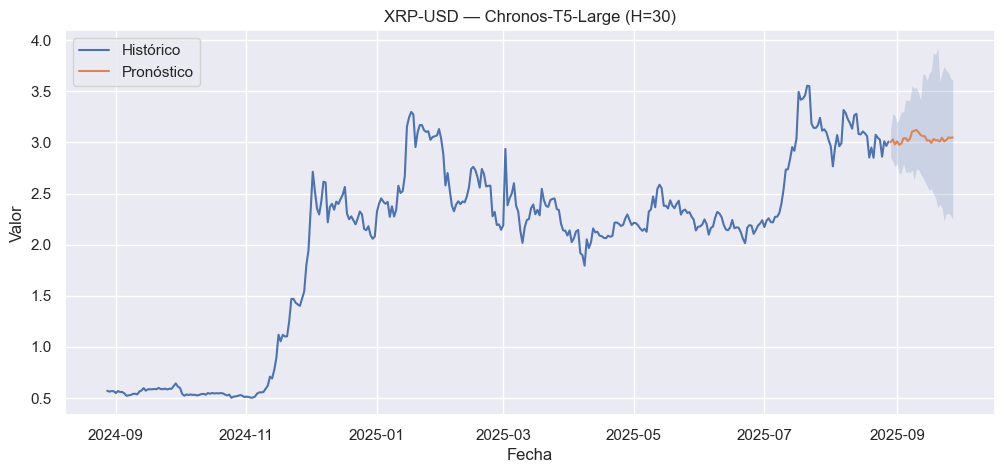

In [50]:
TICKER = "XRP-USD"
PERIODO = "1y"
INTERVALO = "1d"
H = 30
N_SAMPLES = 10

df = download_yf(TICKER, period=PERIODO, interval=INTERVALO)
pipe = load_pipeline()
mean, p05, p95 = forecast(pipe, df["y"].values, H, n_samples=N_SAMPLES)
future_index = make_future_index(df["ds"].iloc[-1], H, freq="D")
df_fc = pd.DataFrame({"ds": future_index})
df_fc["mean"] = np.asarray(mean).reshape(-1)
df_fc["p05"]  = np.asarray(p05).reshape(-1)
df_fc["p95"]  = np.asarray(p95).reshape(-1)
plot_forecast(df, df_fc, f"{TICKER} — Chronos-T5-Large (H={H})")

R2= -1.992769 MAE= 0.19627


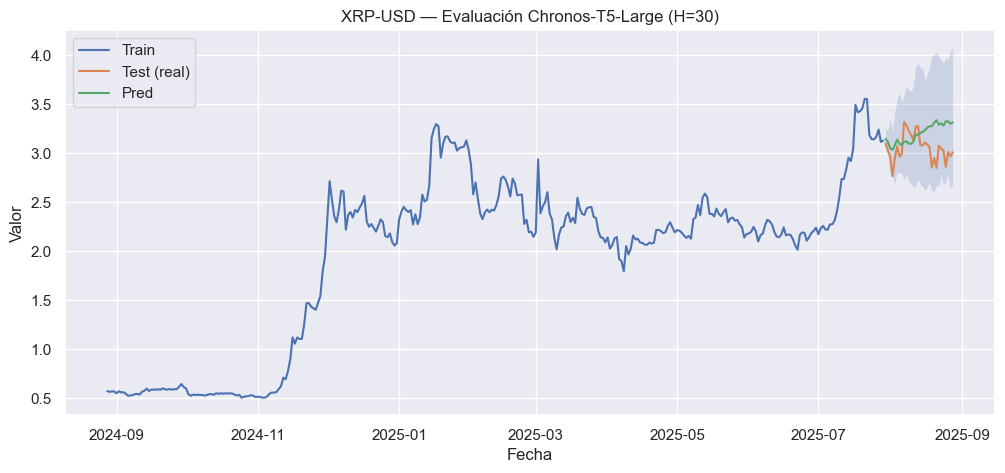

In [51]:
df_all = download_yf(TICKER, period=PERIODO, interval=INTERVALO)
df_train = df_all.iloc[:-H].copy()
df_test = df_all.iloc[-H:].copy()

pipe = load_pipeline()
mean_e, p05_e, p95_e = forecast(pipe, df_train["y"].values, H, n_samples=N_SAMPLES)

df_fc_eval = pd.DataFrame({"ds": df_test["ds"].values})
df_fc_eval["mean"] = np.asarray(mean_e).reshape(-1)
df_fc_eval["p05"]  = np.asarray(p05_e).reshape(-1)
df_fc_eval["p95"]  = np.asarray(p95_e).reshape(-1)

r2 = float(r2_score(df_test["y"].values, df_fc_eval["mean"].values))
mae = float(mean_absolute_error(df_test["y"].values, df_fc_eval["mean"].values))
print("R2=", round(r2,6), "MAE=", round(mae,6))

plot_eval(df_train, df_test, df_fc_eval, f"{TICKER} — Evaluación Chronos-T5-Large (H={H})")
